In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.2
Hub version: 0.12.0
GPU is available


In [ ]:
model_name = "mobilenet_v3_large_100_224"
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
pixels = 224

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

Selected model: mobilenet_v3_large_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5
Input size (224, 224)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
filename = "/content/drive/MyDrive/dataset.zip"
with zipfile.ZipFile(filename, 'r') as zipp:
  zipp.extractall()
  zipp.close()

In [ ]:
data_dir = '/content/Augumented/train'

In [ ]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
do_data_augmentation = True
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 149159 files belonging to 51 classes.
Using 119328 files for training.
Found 149159 files belonging to 51 classes.
Using 29831 files for validation.


In [ ]:
do_fine_tuning = True

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 51)                65331     
                                                                 
Total params: 4,291,763
Trainable params: 4,267,363
Non-trainable params: 24,400
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5
7458/7458 [==============================] - 3314s 442ms/step - loss: 1.4949 - accuracy: 0.8410 - val_loss: 1.3400 - val_accuracy: 0.8935
Epoch 2/5
7458/7458 [==============================] - 3292s 441ms/step - loss: 1.2303 - accuracy: 0.9263 - val_loss: 1.2498 - val_accuracy: 0.9360
Epoch 3/5
7458/7458 [==============================] - 3269s 438ms/step - loss: 1.1579 - accuracy: 0.9482 - val_loss: 1.2036 - val_accuracy: 0.9493
Epoch 4/5
7458/7458 [==============================] - 3295s 442ms/step - loss: 1.1170 - accuracy: 0.9597 - val_loss: 1.1742 - val_accuracy: 0.9523
Epoch 5/5
7458/7458 [==============================] - 3276s 439ms/step - loss: 1.0870 - accuracy: 0.9669 - val_loss: 1.1506 - val_accuracy: 0.9556


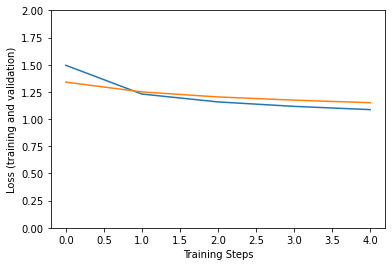

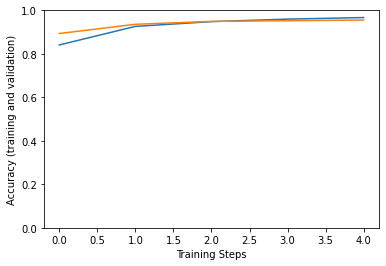

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

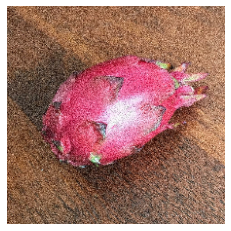

True label: Dragonfruit
Predicted label: Dragonfruit


In [ ]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [ ]:
# from PIL import Image
# import numpy as np

# im1 = Image.open('/content/Potato.png')
# im1 = im1.resize((pixels,pixels))
# im1 = np.reshape(im1,newshape=(1,pixels,pixels,3))
# x_test = np.array(im1)
# x_test = x_test/255
# x_test.dtype = np.float32
class_names

('Baby Potato',
 'Banana',
 'Beetroot',
 'Bittergourd',
 'Black brinjal',
 'Broad Beans',
 'Brown Coconut',
 'Cabbage',
 'CauliFlower',
 'Custard apple',
 'Dragonfruit',
 'Drumstick',
 'French Beans',
 'Garlic',
 'Ginger',
 'Green Apple',
 'Green Capscium',
 'Green Chilli',
 'Green Grapes',
 'Green Pumpkin',
 'Green Zuchini',
 'Guava',
 'JackFruit',
 'Kiran Watermelon',
 'Kiwi',
 'Lemon',
 'Mango',
 'Mango Raw',
 'Muskmelon',
 'Okra',
 'Onion',
 'Ooty Carrot',
 'Orange',
 'Orange Carrot',
 'Papaya',
 'Pear',
 'Pineapple',
 'Pointed gourd',
 'Potato',
 'Radish',
 'Red Apple',
 'Red Capscium',
 'Ridge gourd',
 'Strawberry',
 'Sweet Potato',
 'Sweet lime',
 'Tomato',
 'Yam',
 'Yellaki Banana',
 'Yellow Capscium',
 'Yellow Zuchini')

In [ ]:
import tensorflow as tf

# load image via tf.io
img = tf.io.read_file("/content/MosambiReal.jpg")

# convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
# set the dtypes to align with pytorch for comparison since it will use uint8 by default
tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
# (384, 470, 3)

# resize tensor to 224 x 224
tensor = tf.image.resize(tensor, [224, 224])
# (224, 224, 3)

# add another dimension at the front to get NHWC shape
input_tensor = tf.expand_dims(tensor, axis=0)
# (1, 224, 224, 3)

In [ ]:
# class_names[np.argmax(model.predict(input_tensor))]

In [ ]:
# model.predict(input_tensor)[0][40]

In [ ]:
# class_names[9]

In [ ]:
# class_names

In [ ]:
#model.save("/content/drive/MyDrive/mobilenet_v3.h5")

In [ ]:
#model = tf.keras.models.load_model('/content/drive/MyDrive/mobilenet_v3')

In [ ]:
saved_model_path = "/content/drive/MyDrive/Models/Mobilenet_Augumented"
tf.saved_model.save(model, saved_model_path)

In [ ]:
optimize_lite_model = False 
num_calibration_examples = 0  
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("/content/drive/MyDrive/Tflite_Models/Mobilenet_Augumented.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 17122432 bytes.


In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
  
num_eval_examples = 0  
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

In [ ]:
class_names[np.argmax(model(input_tensor).numpy()[0])]

In [ ]:
class_names[np.argmax(lite_model(input_tensor)[0])]

In [ ]:
import tensorflow as tf

# load image via tf.io
img = tf.io.read_file("/content/RedApple.jpg")

# convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
# set the dtypes to align with pytorch for comparison since it will use uint8 by default
tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
# (384, 470, 3)

# resize tensor to 224 x 224
tensor = tf.image.resize(tensor, [224, 224])
# (224, 224, 3)

# add another dimension at the front to get NHWC shape
input_tensor = tf.expand_dims(tensor, axis=0)
# (1, 224, 224, 3)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Tflite_Models/Mobilenet_Augumented.tflite")
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model_1(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
class_names[np.argmax(lite_model_1(input_tensor)[0])]

In [ ]:
(lite_model_1(input_tensor)[0])